# Predicting blood donations for DrivenData competition

Info: [Driven Data - Predicting blood donations](https://www.drivendata.org/competitions/2/page/6/)

### Contents

* <a href="#data">Import and process data</a>
* <a href="#explore">Exploration</a>
* <a href="#logistic">Logistic regression</a>
* <a href="#results">Prepare results for submission</a>

### About the data
* Months since Last Donation: this is the number of monthis since this donor's most recent donation.
* Number of Donations: this is the total number of donations that the donor has made.
* Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters.
* Months since First Donation: this is the number of months since the donor's first donation.


### Improvements that can be made

The first submission achieved a rank of top ~60 out of 1000. 

There are several improvements that still need to be made: 
* feature selection methods
* outlier analysis
* cross-validation
* evaluating the linear relationships and possibly adding polynomial terms

In [13]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import seaborn as sns

# Import and process data<a id="data"></a>

In [7]:
data_dir = '~/projects/github-analyses/predict-blood-donations/data/'
train = pd.read_csv(data_dir + 'Training_data.csv')
test = pd.read_csv(data_dir + 'Test_Data.csv')

In [8]:
train.columns.values

array(['Unnamed: 0', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'], dtype=object)

In [10]:
col_names = {'Unnamed: 0': 'id', \
                     'Months since Last Donation': 'months_since_last', \
                     'Number of Donations': 'n_donations', \
                     'Total Volume Donated (c.c.)': 'total_volume', \
                     'Months since First Donation': 'months_since_first', \
                     'Made Donation in March 2007': 'donate'}

In [11]:
# clean up the columns to be more python-friendly
train.rename(columns=col_names, inplace=True)
test.rename(columns=col_names, inplace=True)

In [12]:
train.head()

,id,months_since_last,n_donations,total_volume,months_since_first,donate
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [469]:
# total number of months donated
train['months_donated'] = train['months_since_first'] - train['months_since_last']
test['months_donated'] = test['months_since_first'] - test['months_since_last']

In [470]:
# make a range for the total number of months each person has been donating
max_months = max(train.months_donated.unique())
min_months = min(train.months_donated.unique())
months_donated_bin = np.linspace(min_months, max_months, 10)
months_donated_bin

array([  0.        ,  10.66666667,  21.33333333,  32.        ,
        42.66666667,  53.33333333,  64.        ,  74.66666667,
        85.33333333,  96.        ])

In [475]:
# map the months_donated into bins based on the above
digitized = np.digitize(train['months_donated'], months_donated_bin)
train['months_donated_binned'] = digitized
digitized = np.digitize(test['months_donated'], months_donated_bin)
test['months_donated_binned'] = digitized

# Exploration<a id="explore"></a>

In [474]:
train.groupby('donate').mean()

,id,months_since_last,n_donations,total_volume,months_since_first,months_donated,months_donated_binned
donate,,,,,,,
0,368.933790,10.636986,4.716895,1179.223744,34.319635,23.682648,2.899543
1,390.224638,5.637681,7.681159,1920.289855,33.195652,27.557971,3.188406


Those who made a donation in March 2007 were much more likely to have made a donation recently, and have also donated on average for a longer period of time (3.18 versus 2.89).

In [390]:
train[['id', 'donate']].groupby('donate').count()

,id
donate,
0,438
1,138


#### Class imbalance in training set!! Apply correction

In [391]:
# pick a subsample of the non-donating group which is the same size as the donating group
sample_size = sum(train.donate == 1) 
# get the indices for the non-donating group and take a random sub sample
indices_all0 = train[train.donate == 0].index
random_indices = np.random.choice(indices_all0, sample_size, replace=False)
sample_0 = train.loc[random_indices]
# rework the training set
train = train[train.donate == 1]
train = train.append(sample_0)

In [392]:
train[['id', 'donate']].groupby('donate').count()

,id
donate,
0,138
1,138


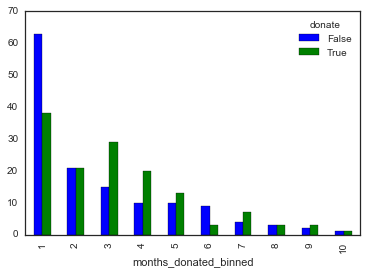

In [393]:
plt.style.use("seaborn-white") 
pd.crosstab(train.months_donated_binned, train['donate'].astype(bool)).plot(kind='bar')

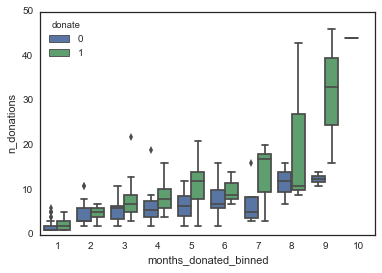

In [394]:
sns.boxplot(x='months_donated_binned', y="n_donations", hue='donate', data=train);

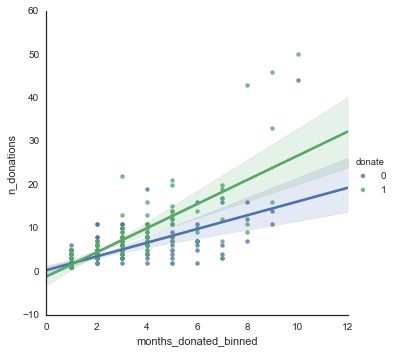

In [396]:
sns.lmplot('months_donated_binned', 'n_donations', data=train, hue='donate' )

# Logistic regression<a id="logistic"></a>

In [397]:
train.columns

Index(['id', 'months_since_last', 'n_donations', 'total_volume',
       'months_since_first', 'donate', 'months_donated',
       'months_donated_binned'],
      dtype='object')

In [401]:
# split dataframe
y, X = dmatrices('donate ~ months_since_last + n_donations + months_since_first', train, return_type="dataframe")
# flatten y into a 1-D array
y = np.ravel(y)

In [402]:
# logistic regressor on 'donate'
model = LogisticRegression()
model = model.fit(X, y)

# training set accuracy
model.score(X, y)

0.65579710144927539

In [479]:
# (recall that the data is split 50/50 True/False, so 65% is an improvement)

In [480]:
# make an intercept column for the model to work
train['Intercept'] = 1

In [371]:
y_train = np.array(train['donate'])
X_train = np.array(train[X.columns.values])

In [413]:
train[X.columns.values].head(3)

,Intercept,months_since_last,n_donations,months_since_first
0,1,2,50,98
1,1,0,13,28
2,1,1,16,35


In [407]:
# generate class probabilities for (donate = False, donate = True)
probs = model.predict_proba(X_train)
predictions = model.predict(X_train)

In [408]:
print(metrics.accuracy_score(y_train, predictions))
print(metrics.roc_auc_score(y_train, probs[:, 1]))

0.630434782609
0.725372820836


AUC is about 73%, which is decent.

In [409]:
print(metrics.confusion_matrix(y_train, predictions))
print(metrics.classification_report(y_train, predictions))

[[ 72  66]
 [ 36 102]]
             precision    recall  f1-score   support

          0       0.67      0.52      0.59       138
          1       0.61      0.74      0.67       138

avg / total       0.64      0.63      0.63       276



* 74% of the people who donated were predicted to donate (recall)
* 61% of the people who were predicted to donate actually donated (precision)

# Prepare results for submission<a id="results"></a>

In [416]:
test[X.columns.values].head(3)

,Intercept,months_since_last,n_donations,months_since_first
0,1,2,12,52
1,1,21,7,38
2,1,4,1,4


In [417]:
X_test = np.array(test[X.columns.values])

In [431]:
# see if the model makes sense. Would guess this person would have a low probability of donating
model.predict_proba([1,21,7,38])

/Users/Heidi/anaconda/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.71987753,  0.28012247]])

The probability that there was a donation is the 2nd one, which needs to be extracted (probability of NOT donating is 72%)

In [427]:
predictions = model.predict_proba(X_test)

In [433]:
# extract probability donate = True
predictions_donate = predictions[:,1]

In [453]:
# add back the ID field for the submission file
results = pd.DataFrame(test['id'].copy())

In [454]:
type(results)

pandas.core.frame.DataFrame

In [455]:
results['Made Donation in March 2007'] = predictions_donate

In [456]:
results.head(3)

,id,Made Donation in March 2007
0,659,0.725088
1,276,0.280122
2,263,0.505562


In [457]:
results.to_csv(data_dir + 'results_submission.csv', index_label='id', index=False)

In [460]:
len(results)

200